In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

# run for all cells (OFF LINE)

run 
```
python3 stcl_batch.py [DATASET]
```

datasets
* 20180618
* 20180621
* 20180626
* 20180828

## load stim and spike data

In [12]:
folder_name = "data"

#dataset_name = "20180618"
#dataset_name = "20180621"
dataset_name = "20180626"
#dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

# channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]   # NOT NEEDED ANYMORE
# info["channel_names"]
# info["cell_types"]


['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['12a', '12b', '12c', '13a', '13b', '13c', '13d', '13e', '14a', '14b', '14c', '14d', '16a', '16b', '16c', '17a', '17b', '17c', '17d', '21a', '21b', '21c', '21d', '21e', '22a', '22b', '23a', '23b', '23c', '23d', '25a', '25b', '25c', '26a', '26b', '26c', '26d', '27a', '27b', '27c', '27d', '28a', '28b', '28c', '31a', '31b', '31c', '31d', '32a', '32b', '32c', '33a', '33b', '33c', '33d', '35a', '35b', '35c', '35d', '35e', '35f', '35g', '36a', '36b', '36c', '36d', '37a', '37b', '37c', '37d', '37e', '38a', '41a', '41b', '41c', '41d', '42a', '42b', '42c', '43a', '43b', '43c', '45a', '45b', '45c', '46a', '46b', '47a', '48a', '48b', '48c', '48d', '48e', '51a', '51b', '53a', '53b', '53c', '53d', '54a', '54b', '54c', '54d', '56a', '56b', '58a', '61a', '61b', '62a', '62b', '63a', '63b', '63c', '63d', '63e', '64a', '65a', '65b', '65c', '68a', '68b', '71a', '71b', '71c', '72a', '72b', '72c', '72d', '72e', '73a', 

In [13]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": channel_names, "number_of_samples": num_samples})
# num_samples_df

## read clustering results

In [16]:
folder_name = "{}_tap{}_stc_classic_cluster".format(dataset_name,tap)
filename = os.path.join(folder_name, "weights.csv")

weights = pd.read_csv(filename)
# weights.merge(num_samples_df, on="channel_name", how="outer")
weights.head()

,channel_name,weight1,weight2
0,ch_22a,0.425402,0.574598
1,ch_22b,0.480898,0.519102
2,ch_23b,0.494718,0.505282
3,ch_25b,0.453760,0.546240
4,ch_26a,0.484023,0.515977


In [23]:
weights["min_weight"] = np.minimum(weights["weight1"], weights["weight2"])
weights

,channel_name,weight1,weight2,min_weight
0,ch_22a,0.425402,0.574598,0.425402
1,ch_22b,0.480898,0.519102,0.480898
2,ch_23b,0.494718,0.505282,0.494718
3,ch_25b,0.453760,0.546240,0.453760
4,ch_26a,0.484023,0.515977,0.484023
5,ch_26b,0.502907,0.497093,0.497093
6,ch_27a,0.500097,0.499903,0.499903
7,ch_33b,0.505824,0.494176,0.494176
8,ch_36c,0.479247,0.520753,0.479247
9,ch_37b,0.500652,0.499348,0.499348


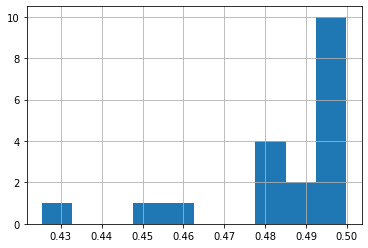

In [27]:
weights["min_weight"].hist()
plt.savefig("{}/weights_min_hist.png".format(folder_name))